# Testing Real Estate Predictions
The purpose of this notebook is to load a trained AI model for NJ real estate and use it to generate predictions agianst a pre-processed data file which will be compared against known property values to access the accuracy of the model.

# 1 Load and Scale Sample Data
First we'll load a sample pre-processed property file from our workspace and use the same scaler from our model creation to produce a consistent normalized view of the input data.

In [23]:
import numpy as np
import pandas as pd
import os

current_directory = os.getcwd()
print(current_directory)

/Users/jleelong/workspace/sample-similarity-search


In [13]:
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

file_dir = 'data'
model_name = '0311'

file_path = os.path.join(file_dir, 'archived', model_name + ".pkl")
if os.path.exists(file_path):
    df = pd.read_pickle(file_path).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    raise ValueError(f"{file_path} does not exist")
print(df.shape)
df

(1503, 20)


,lat,lng,No_Of_Dwellings,Corporate_Owned,Absentee,updated_at,Sq_Ft,Building_Class,Yr_Built,TaxRate,TaxRatio,RateYear,Recorded_Taxes,Year_1,Land_Assmnt_1,Building_Assmnt_1,Total_Assmnt_1,Sale_Price,Sale_Month,Sale_Year
0,39.998516,-74.767268,1,False,0,1736519885000,2239,18,1966,3.125,69.55,2024,7412.54,2025,54000,172000,226000,279000,8,2017
1,39.992513,-74.764010,1,False,0,1736519885000,1808,18,1972,3.125,69.55,2024,6958.11,2025,49200,162100,211300,330000,8,2021
2,39.997205,-74.761201,1,False,0,1736519885000,1392,18,1974,3.125,69.55,2024,6296.22,2025,51800,139400,191200,132000,5,2002
3,39.995535,-74.764333,1,False,0,1736519885000,1576,18,1973,3.125,69.55,2024,6404.89,2025,48500,146000,194500,203500,6,2020
4,39.999161,-74.758980,1,False,0,1736519885000,2310,17,1990,3.125,69.55,2024,9859.25,2025,67000,232400,299400,184825,9,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,39.998022,-74.759900,1,False,0,1736519885000,2540,17,1988,3.125,69.55,2024,10333.43,2025,67900,245900,313800,478000,11,2021
1499,40.005531,-74.770172,1,False,0,1736519885000,980,16,1954,3.125,69.55,2024,4481.77,2025,42700,93400,136100,133500,6,2011
1500,39.995548,-74.749467,1,False,0,1736519885000,1911,17,1989,3.125,69.55,2024,8018.46,2025,52600,190900,243500,134490,1,1990
1501,39.996547,-74.771822,1,False,0,1736519885000,1299,18,1960,3.125,69.55,2024,6118.39,2025,51900,133900,185800,94900,9,1987


In [14]:
from sklearn.preprocessing import MinMaxScaler
import joblib

X = df.drop('Sale_Price', axis=1).values
y = df['Sale_Price'].values

file_path = os.path.join(file_dir, 'scaler', model_name + ".features")
if os.path.exists(file_path):
    X_scaler = joblib.load(file_path)
    X = X_scaler.transform(X)
else:
    raise ValueError(f"scaler for the model does not exist at {file_path}")


## 2 Generate Predictions
Now we can load the pre-trained model and use the input data to generate predictions

In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

file_path = os.path.join(file_dir, 'models', model_name + ".keras")
if os.path.exists(file_path):
    model = load_model(file_path)
else:
    raise ValueError(f"model does not exist at {file_path}")

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

print(X.shape)
X

(1503, 19)


array([[0.44061976, 0.26223379, 0.5       , ..., 0.42199803, 0.63636364,
        0.89285714],
       [0.31521424, 0.33770644, 0.5       , ..., 0.38582677, 0.63636364,
        0.96428571],
       [0.4132249 , 0.40276796, 0.5       , ..., 0.33636811, 0.36363636,
        0.625     ],
       ...,
       [0.37861472, 0.67461595, 0.5       , ..., 0.46505906, 0.        ,
        0.41071429],
       [0.39947734, 0.15673006, 0.5       , ..., 0.32308071, 0.72727273,
        0.35714286],
       [0.42074522, 0.3215291 , 0.5       , ..., 0.39443898, 0.54545455,
        0.67857143]])

In [17]:
predictions = model.predict(X)

print(f"MAE: {mean_absolute_error(y, predictions)}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 36878.71875


In [18]:
print(f"MSE: {np.sqrt(mean_absolute_error(y, predictions))}")

MSE: 192.03832625286026


In [19]:
print(f"EVS: {explained_variance_score(y, predictions)}")

EVS: 0.7607493901383943


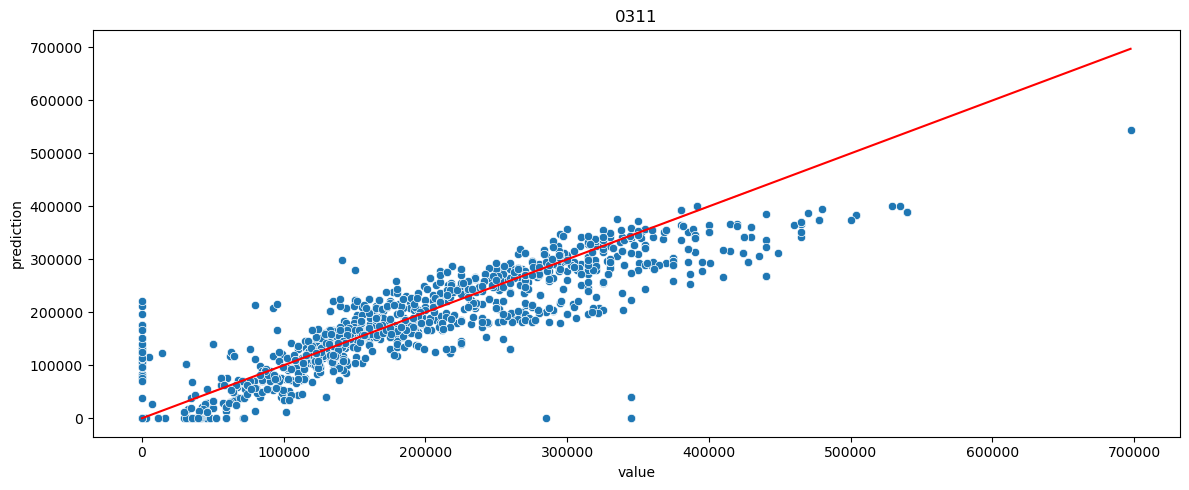

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

y_df = pd.DataFrame(y, columns=['value'])
predictions_df = pd.DataFrame(predictions, columns=['prediction'])
predictions_df['value'] = y

fig, axes = plt.subplots(1, 1, figsize=(12, 5))
sns.scatterplot(x='value', y='prediction', data=predictions_df, ax=axes)
sns.lineplot(x='value', y='value', data=y_df, ax=axes, color='r')
axes.set_title(model_name)
plt.tight_layout()
plt.show()

In [21]:
errors = y.reshape(X.shape[0], 1) - predictions

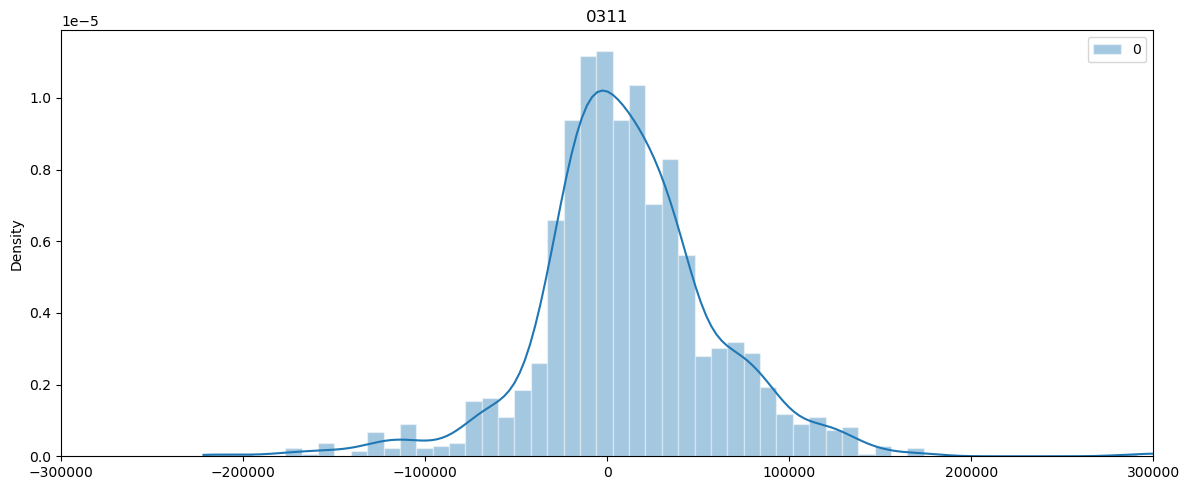

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
sns.histplot(errors, kde=True, stat='density', alpha=0.4, edgecolor=(1,1,1,0.4), ax=axes)
axes.set_title(model_name)
axes.set_xlim(-300000, 300000)
plt.tight_layout()
plt.show()